# CSCE 633 :: Machine Learning :: Texas A&M University :: Fall 2023

# Final project: Sentiment Analysis
**Name: Siddharrth Priyadharsan Muthusamy**  
**UIN: 434002400 **  

### 2A Data pre-processing

In this section, we will pre-process the data by removing the punctuation and stopwords and converting all words to lowercase. 

Moreover, converting the stars into three levels: Positive > 3, negative <= 2, and neutral = 3. 

We will give the index value for these three levels as follows:
0 - negative
1 - neutral
2 - positive


We will declare all the libraries below:

In [1]:
# Import the libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot_graph
import warnings
from tqdm import tqdm

import copy
from copy import deepcopy

from numpy import *
from typing import Tuple

from skimage.color import rgb2gray
from scipy.stats import pearsonr, skew
import seaborn as plot_heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import torch
import transformers 
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from transformers import BertModel, BertTokenizer
import torch.nn as nn
from torch.nn import CrossEntropyLoss, Dropout, Linear, ReLU, Module
from torch.utils.data import DataLoader, Dataset
from transformers import get_linear_schedule_with_warmup, AdamW


In [33]:
# to install the library for stop words
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siddharrthpriyadharsan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/siddharrthpriyadharsan/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/siddharrthpriyadharsan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In this section, we would pre-process the data:
1) Fetch the data from the csv file
2) remove punctuation and stopwords
3) Convert all words to lowercase

In [2]:
# reading training data from the yelp_review_train.csv file and loading it in a dataframe
training_data_file_path = "yelp_review_train.csv"

df = pd.read_csv(training_data_file_path)
print("Glimpse of training data")
df.head()


Glimpse of training data


,text,stars
0,Went for lunch and found that my burger was me...,2.0
1,I needed a new tires for my wife's car. They h...,5.0
2,Jim Woltman who works at Goleta Honda is 5 sta...,5.0
3,Been here a few times to get some shrimp. The...,4.0
4,This is one fantastic place to eat whether you...,5.0


In [3]:
# reading training data from the yelp_review_test.csv file and loading it in a dataframe
testing_data_file_path = "yelp_review_test.csv"

df_test = pd.read_csv(testing_data_file_path)
print("Glimpse of testing data")
df_test.head()

Glimpse of testing data


,text,stars
0,"Hidden treasure! Awesome service, delicious fo...",5.0
1,My family and I have been patients since I wa...,5.0
2,"I rarely get pedicures, but Blue Nail's practi...",5.0
3,"We came with a large group, may of the items w...",2.0
4,The view is great from Morgan's Pier. The bart...,2.0


In [35]:
# function to print sample data from the input/output set (it will print the first 10 records)
def print_sample_data(input_list, output_list):
    
    for i in range(10):
        print(f"Processed input string = {input_list[i]}")
        if output_list[i] == 0:
            print("Output label = negative")
        elif output_list[i] == 1:
            print("Output label = neutral")
        else:
            print("Output label = positive")
        
        print()
        print()

In [34]:
# max padded length to be set
MAX_LEN = 512

# size of each mini batch
BATCH_SIZE = 16

no_of_records = len(df)
input_records = []
processed_input_records = []
processed_output_records = []
target = []
stop_words = set(stopwords.words("english"))

# 0 - negative, 1 - neutral, 2 - positive
output_labels = ["negative", "neutral", "positive"]

# check if CUDA is available, if yes, use it
device = torch.device("cpu")
if torch.cuda.is_available():
    cuda_device = torch.device("cuda")
    device = cuda_device

# populating the feature attributes as a list to maintain input and output records for training dataset
for i in range(no_of_records):
    target.append(df.values[i][1])
    input_records.append(df.values[i][0])      
    
# process both the input and output with respect to the requirements given in the problem statement
# 140000 is nearly 80% of the total size of the training dataset
for i in range(140000):
    # converting the input string to lowercase
    input_string = input_records[i].lower()
    updated_string = ""

    # remove punctuations
    input_string = input_string.translate(str.maketrans('', '', string.punctuation))

    # remove stop words
    word_tokens = word_tokenize(input_string)
    for word_token in word_tokens:
        if not word_token in stop_words:
            updated_string += word_token + " "
            
    processed_input_records.append(updated_string)
    
    # categorising the output based on the rating value
    if int(target[i]) > 3:
        processed_output_records.append(2)
    elif int(target[i]) == 3:
        processed_output_records.append(1)
    else:
        processed_output_records.append(0)


print("Training data processing completed.")
print("Following are some records (processed input string with updated output labels) from the training set")
print()

for i in range(10):
        print(f"Original input  = {input_records[i]}")
        print(f"Processed input = {processed_input_records[i]}")
        if target[i] == 0:
            print("Output label = negative")
        elif target[i] == 1:
            print("Output label = neutral")
        else:
            print("Output label = positive")
        
        print()
        print()


Training data processing completed.
Following are some records (processed input string with updated output labels) from the training set

Original input  = Went for lunch and found that my burger was meh.  What was obvious was that the focus of the burgers is the amount of different and random crap they can pile on it and not the flavor of the meat.  My burger patty seemed steamed and appeared to be a preformed patty, contrary to what is stated on the menu.    I can get ground beef from Kroger and make a burger that blows them out of the water.
Processed input = went lunch found burger meh obvious focus burgers amount different random crap pile flavor meat burger patty seemed steamed appeared preformed patty contrary stated menu get ground beef kroger make burger blows water 
Output label = positive


Original input  = I needed a new tires for my wife's car. They had to special order it and had it the next day, I dropped it off in the morning before work and they called a few hours lat

In [6]:
# loading validation dataset

processed_input_records_validation = []
processed_output_records_validation = []

# process both the input and output with respect to the requirements given in the problem statement for the validation dataset
# validation dataset takes up the remaining 20% of the training dataset
for i in range(140000, no_of_records - 1):
    # converting the input string to lowercase
    input_string = input_records[i].lower()
    updated_string = ""

    # remove punctuations
    input_string = input_string.translate(str.maketrans('', '', string.punctuation))

    # remove stop words
    word_tokens = word_tokenize(input_string)
    for word_token in word_tokens:
        if not word_token in stop_words:
            updated_string += word_token + " "
            
    processed_input_records_validation.append(updated_string)
    
    # categorising the output based on the rating value
    if int(target[i]) > 3:
        processed_output_records_validation.append(2)
    elif int(target[i]) == 3:
        processed_output_records_validation.append(1)
    else:
        processed_output_records_validation.append(0)


print("Validation data processing completed.")
print("Following are some records (processed input string with updated output labels) from the validation set")
print_sample_data(processed_input_records_validation, processed_output_records_validation)

Validation data processing completed.
Following are some records (processed input string with updated output labels) from the validation set
Processed input string = nvr provide competitive rates many people working qualified numerous mistakes made loan process would strongly advise going elsewhere ignore discount ryan homes advertises using affiliates use parties determined btw reviews much worse recently reset 
Output label = negative


Processed input string = first place eat group left nashville international airport disappoint breakfast southern comfort food hit right spot getting plane new jersey 4 morning empty stomachs 18 familystyle buffet seated large table eat strangers fun communicate walks life fair warning sweet teais sweet however rest food enjoyable ate everything enjoy fried chicken grits smoked sausage biscuit gravy selection day 
Output label = positive


Processed input string = never would discovered place joy tsin lau hadnt horrendously crowded sunday friend decid

In [25]:
# loading testing dataset

input_records_test = []
processed_input_records_test = []
processed_output_records_test = []
target_test = []

no_of_test_records = len(df_test)

# populating the feature attributes as a list to maintain input and output records
for i in range(no_of_test_records):
    target_test.append(df_test.values[i][1])
    input_records_test.append(df_test.values[i][0])    
    
# process both the input and output with respect to the requirements given in the problem statement
for i in range(no_of_test_records):
    # converting the input string to lowercase
    input_string = input_records_test[i].lower()
    updated_string = ""

    # remove punctuations
    input_string = input_string.translate(str.maketrans('', '', string.punctuation))

    # remove stop words
    word_tokens = word_tokenize(input_string)
    for word_token in word_tokens:
        if not word_token in stop_words:
            updated_string += word_token + " "
            
    processed_input_records_test.append(updated_string)
    
    # categorising the output based on the rating value
    if int(target_test[i]) > 3:
        processed_output_records_test.append(2)
    elif int(target_test[i]) == 3:
        processed_output_records_test.append(1)
    else:
        processed_output_records_test.append(0)


print("Testing data processing completed.")
print("Following are some records (processed input string with updated output labels) from the testing set:")
print()

for i in range(10):
        print(f"Original input  = {input_records_test[i]}")
        print(f"Processed input = {processed_input_records_test[i]}")
        if target_test[i] == 0:
            print("Output label = negative")
        elif target_test[i] == 1:
            print("Output label = neutral")
        else:
            print("Output label = positive")
        
        print()
        print()

Testing data processing completed.
Following are some records (processed input string with updated output labels) from the testing set:

Original input  = Hidden treasure! Awesome service, delicious food and extremely affordable. I love the vibe in the back.
Hope this place sticks around it's great for the area
Processed input = hidden treasure awesome service delicious food extremely affordable love vibe back hope place sticks around great area 
Output label = positive


Original input  = My family and I have been patients since I  was 5 years old (34 now!). The trust and quality of service has always made every experience a warm one. They also keep in great contact to remind you of upcoming   visits or just to tell you that you are missed. This is truly a team, a family business and it shows.
Processed input = family patients since 5 years old 34 trust quality service always made every experience warm one also keep great contact remind upcoming visits tell missed truly team family bu

### 2B Input data preparation

In this section, we will deal with handling the input of the Transformer model is a fixed length
review sequence where integer numbers represent words. Review data is padded to a fixed length of 128.

In [9]:
# I am using the BERT tokenizer for the encoding
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

# Class for representing the review data
class DatasetObject(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        input_size = len(self.inputs)
        return input_size

    def __getitem__(self,item):
        
        input_string = str(self.inputs[item])
        encoding = tokenizer.encode_plus(input_string, max_length=256, return_attention_mask=True, add_special_tokens=True, return_token_type_ids=False, return_tensors='pt', pad_to_max_length=True, truncation=True)

        attention_mask = encoding["attention_mask"].flatten()
        input_id_list = encoding["input_ids"].flatten()
        
        output = self.outputs[item]
        output_list = torch.tensor(output, dtype=torch.long)

        data_object_as_dict = {}
        data_object_as_dict["input"] = input_string
        data_object_as_dict["output"] = output_list
        data_object_as_dict["attention_mask"] = attention_mask
        data_object_as_dict["input_id_list"] = input_id_list
        
        return data_object_as_dict


# Class for the Sentiment analysis model 1
class SentimentAnalysisModel1(Module):
    def __init__(self):
        super(SentimentAnalysisModel1, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-cased", return_dict=False)
  
    def forward(self, input_ids, attention_mask):
        _, bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # intializing the layers to be applied on top of the existing model

        linear_layer = Linear(768, 128, device=device)
        relu_layer = ReLU()
        output_layer = Linear(128, 3, device=device)

        model_output = linear_layer(bert_output)
        model_output = relu_layer(model_output)
        model_output = output_layer(model_output)
        
        
        model_output = bert_output
        return model_output


In [10]:
# function to create a dataset loader using the input and output records
def load_data(inputs, outputs):
    dataset_object = DatasetObject(inputs = np.array(inputs), outputs = np.array(outputs))
    data_loader_object = DataLoader(dataset_object, batch_size=BATCH_SIZE)
    return data_loader_object

# creating data loader for training, validation and testing sets
data_loader_for_training_set = load_data(processed_input_records, processed_output_records)
data_loader_for_testing_set = load_data(processed_input_records_test, processed_output_records_test)
data_loader_for_validation_set = load_data(processed_input_records_validation, processed_output_records_validation)


### 2C Tranformer implementation

In this section, the tranformer model is initialized and is ready to be used for training and evaluation.
I am using the pretrained BERT transformer model, and I am adding more layers on top of the existing model.

In the previous section, we have declared the first transformer model - SentimentAnalysisModel1

This has two layers on top of the BERT Model:
1) One linear layer (fully connected) 
2) ReLU (activation function)
3) Output layer (which is again a linear layer)


In [11]:
warnings.filterwarnings('ignore')

# EPOCH LIMIT is 6
epoch_limit = 6

# creating the first tranformer model
tranformer_model1 = SentimentAnalysisModel1()
tranformer_model1 = tranformer_model1.to(device)

# creating the optimizer (stochastic gradient descent usin AdamW) and scheduler objects for the transformer model 1
no_of_steps_for_training = epoch_limit * len(data_loader_for_training_set)
optimizer = AdamW(tranformer_model1.parameters(), correct_bias=False, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=no_of_steps_for_training, num_warmup_steps=0)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 2D: Model training

In this section, I will be training the transformer model using the given dataloaders for training and validation datasets.
And I will be plotting the training and validation curves for loss and accuracy and save the best model with highest validation accuracy.

In [12]:
# function to calculate the average of the elements in the list
def calculate_mean(list_of_elements):
    list_size = len(list_of_elements)
    total_sum = 0.0
    for element in list_of_elements:
        total_sum += element

    return total_sum / list_size

# function to train the transformer model using the given data loaders for training and validation
def train_tranformer_model(dataset, learning_model, number_of_samples, scheduler, optimizer):

    no_of_correct_classifications = 0
    x = 0
    loss_list = []
    learning_model = learning_model.train()
    loss_function = CrossEntropyLoss().to(device)
    
    # iterating over each mini batch
    for data in dataset:
        input_id_list = data["input_id_list"].to(device)
        output_values = data["output"].to(device)
        attention_mask = data["attention_mask"].to(device)
        
        predicted_outputs = learning_model(input_ids=input_id_list, attention_mask=attention_mask)
        _, predictions = torch.max(predicted_outputs, dim=1)
        loss_value = loss_function(predicted_outputs, output_values)
        total_size = len(predictions)
        
        # calculating the number of records that are correctly classified
        for i in range(total_size):
            if predictions[i] == output_values[i]:
                no_of_correct_classifications += 1

        loss_list.append(loss_value.item())

        loss_value.backward()
        nn.utils.clip_grad_norm_(learning_model.parameters(), max_norm=1.0)
        scheduler.step()
        optimizer.step()
        optimizer.zero_grad()
    
    # returning the average loss and accuracy of the model
    return calculate_mean(loss_list), no_of_correct_classifications / number_of_samples


In [13]:
# function to evaluate the predictions of the tranformer model with respect to the given tranformer model and input dataloader object
def evaluate_transformer_model(dataset, learning_model, number_of_samples):
    no_of_correct_classifications = 0
    loss_list = []
    learning_model = learning_model.eval()
    loss_function = CrossEntropyLoss().to(device)

    with torch.no_grad():
        # iterating over each mini batch
        for data in dataset:

            input_id_list = data["input_id_list"].to(device)
            attention_mask = data["attention_mask"].to(device)
            output_values = data["output"].to(device)
            
            predicted_outputs = learning_model(input_ids=input_id_list, attention_mask=attention_mask)
            _, predictions = torch.max(predicted_outputs, dim=1)
            loss_value = loss_function(predicted_outputs, output_values)
            
            total_size = len(predictions)

            for i in range(total_size):
                if predictions[i] == output_values[i]:
                    no_of_correct_classifications += 1

            loss_list.append(loss_value.item())
            
    # returning the average loss and accuracy of the model
    return calculate_mean(loss_list), no_of_correct_classifications / number_of_samples

In [14]:
# function to predict the model with respect to the given tranformer model and input dataloader object
def predict_output_from_model(dataset, learning_model):
    input_list = []
    predicted_output_list = []
    predicted_output_probability_list = []
    original_output_list = []
    learning_model = learning_model.eval()

    with torch.no_grad():
        # iterating over each mini batch
        for data in dataset:
 
            input_id_list = data["input_id_list"].to(device)
            attention_mask = data["attention_mask"].to(device)
            output_values = data["output"].to(device)
            inputs = data["input"]
            
            predicted_outputs = learning_model(input_ids=input_id_list, attention_mask=attention_mask)
            _, predictions = torch.max(predicted_outputs, dim=1)

            input_list.extend(inputs)
            original_output_list.extend(output_values)
            predicted_output_probability_list.extend(predicted_outputs)
            predicted_output_list.extend(predictions)
            
    predicted_output_list = torch.stack(predicted_output_list).cpu()
    predicted_output_probability_list = torch.stack(predicted_output_probability_list).cpu()
    original_output_list = torch.stack(original_output_list).cpu()

    return input_list, original_output_list, predicted_output_list, predicted_output_probability_list 


Epoch : 1
Training data
Training accuracy = 0.415
Training loss = 4.991860927097381
Validation data
Validation accuracy = 0.522
Validation loss = 4.676063941075252


Epoch : 2
Training data
Training accuracy = 0.571
Training loss = 4.6748874679444326
Validation data
Validation accuracy = 0.633
Validation loss = 4.63239002081064


Epoch : 3
Training data
Training accuracy = 0.645
Training loss = 4.62859919454181
Validation data
Validation accuracy = 0.641
Validation loss = 4.621369992769682


Epoch : 4
Training data
Training accuracy = 0.682
Training loss = 4.59059918464208
Validation data
Validation accuracy = 0.679
Validation loss = 4.60089110154371


Epoch : 5
Training data
Training accuracy = 0.702
Training loss = 4.48159828001219
Validation data
Validation accuracy = 0.711
Validation loss = 4.580664677253137


Epoch : 6
Training data
Training accuracy = 0.763
Training loss = 4.179223123200783
Validation data
Validation accuracy = 0.742
Validation loss = 4.550598947084867




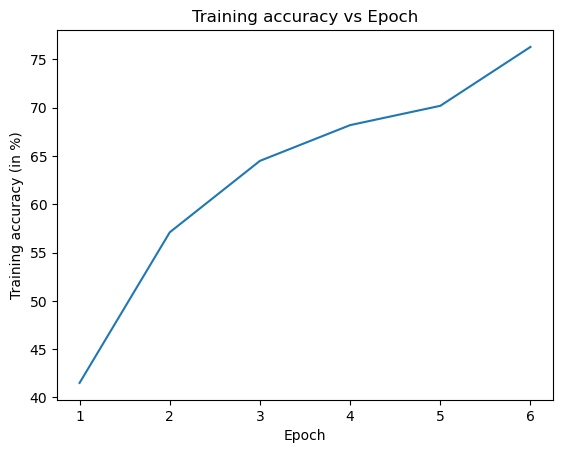

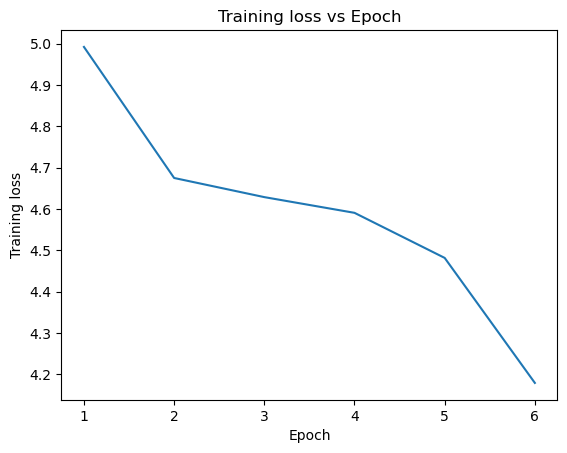

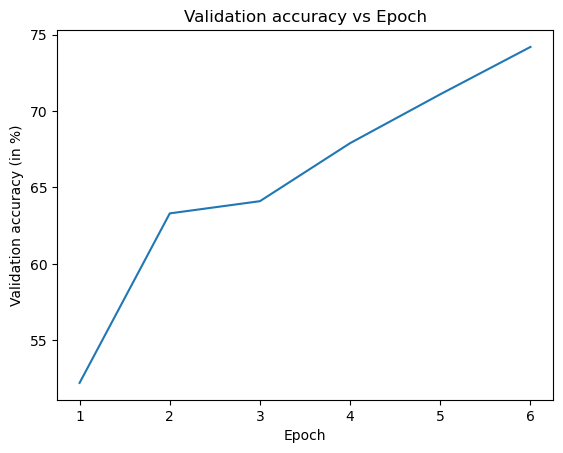

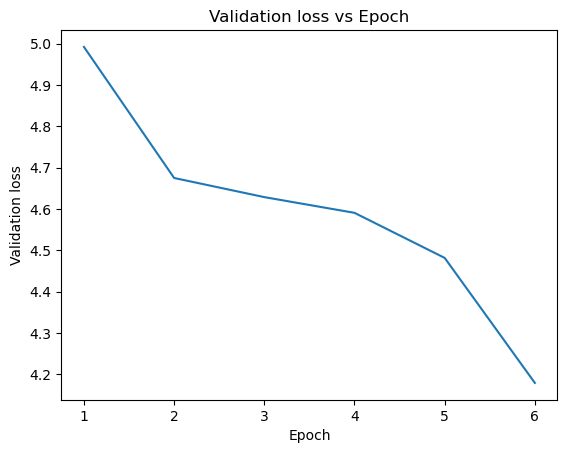

In [27]:
import copy
from copy import deepcopy

warnings.filterwarnings('ignore')
maximum_accuracy = 0
training_accuracy_list = []
training_loss_list = []
validation_loss_list = []
validation_accuracy_list = []
indexes = []
best_model_state = deepcopy(tranformer_model1.state_dict())


# calculating the loss and accuracy of training and validation datasets for each epoch
for i in range(epoch_limit):
    print(f"Epoch : {i + 1}")

    training_loss, training_accuracy = train_tranformer_model(data_loader_for_training_set, tranformer_model1, len(processed_output_records), scheduler, optimizer)

    print("Training data")
    print(f"Training accuracy = {training_accuracy}")
    print(f"Training loss = {training_loss}")

    validation_loss, validation_accuracy = evaluate_transformer_model(data_loader_for_validation_set, tranformer_model1, len(processed_output_records_validation))

    print("Validation data")
    print(f"Validation accuracy = {validation_accuracy}")
    print(f"Validation loss = {validation_loss}")

    training_accuracy_list.append(training_accuracy * 100)
    validation_accuracy_list.append(validation_accuracy * 100)
    training_loss_list.append(training_loss)
    validation_loss_list.append(validation_loss)
    indexes.append(i)
    
    print()
    print()

    if maximum_accuracy <= validation_accuracy:
        maximum_accuracy = validation_accuracy
        best_model_state = deepcopy(tranformer_model1.state_dict())

        
# saving the best model (which had the maximum validation accuracy)
torch.save(best_model_state, "./best_model1.pt")
        
# printing the Training accuracy vs Epoch graph
plot_graph.plot(indexes, training_accuracy_list)
plot_graph.xlabel("Epoch")
plot_graph.ylabel("Training accuracy (in %)")
plot_graph.title("Training accuracy vs Epoch")
plot_graph.show()

print()
print()

# plotting the Training loss vs Epoch graph
plot_graph.plot(indexes, training_loss_list)
plot_graph.xlabel("Epoch")
plot_graph.ylabel("Training loss")
plot_graph.title("Training loss vs Epoch")
plot_graph.show()

print()
print()

# printing the Validation accuracy vs Epoch graph
plot_graph.plot(indexes, validation_accuracy_list)
plot_graph.xlabel("Epoch")
plot_graph.ylabel("Validation accuracy (in %)")
plot_graph.title("Validation accuracy vs Epoch")
plot_graph.show()

print()
print()

# plotting the Validation loss vs Epoch graph
plot_graph.plot(indexes, training_loss_list)
plot_graph.xlabel("Epoch")
plot_graph.ylabel("Validation loss")
plot_graph.title("Validation loss vs Epoch")
plot_graph.show()

In this section, I will build another transformer model with a different set of hyper parameters (activation, number of hidden layers, number of nodes in each layer) and see if it is performing better than the first model.

As we see below, we have declared the second transformer model - SentimentAnalysisModel2

This has four layers on top of the BERT Model:
1) One linear layer (fully connected) 
2) ReLU (activation function)
3) Two dropout layers (with dropout probabilities 0.3 and 0.5)
4) Output layer (which is again a linear layer)

This time, we have increased the number of nodes in the linear layer by 2x.


In [21]:
# Class for the Sentiment analysis model 2
class SentimentAnalysisModel2(Module):
    def __init__(self):
        super(SentimentAnalysisModel2, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-cased", return_dict=False)
  
    def forward(self, input_ids, attention_mask):
        _, bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # intializing the layers to be applied on top of the existing model
        drop_layer1 = Dropout(p=0.3)
        drop_layer2 = Dropout(p=0.5)
        linear_layer = Linear(768, 256, device=device)
        relu_layer = ReLU()
        output_layer = Linear(256, 3, device=device)

        model_output = drop_layer1(bert_output)
        model_output = linear_layer(model_output)
        model_output = drop_layer2(model_output)
        model_output = relu_layer(model_output)
        model_output = output_layer(model_output)
        
        return model_output

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch : 1
Training data
Training accuracy = 0.32
Training loss = 1.1522196067704096
Validation data
Validation accuracy = 0.315
Validation loss = 1.1551989316940308


Epoch : 2
Training data
Training accuracy = 0.314
Training loss = 1.1368847214986408
Validation data
Validation accuracy = 0.265
Validation loss = 1.1691344884725718


Epoch : 3
Training data
Training accuracy = 0.326
Training loss = 1.1177770022361997
Validation data
Validation accuracy = 0.475
Validation loss = 1.071511053122007


Epoch : 4
Training data
Training accuracy = 0.354
Training loss = 1.1004765402703058
Validation data
Validation accuracy = 0.285
Validation loss = 1.1104581722846398


Epoch : 5
Training data
Training accuracy = 0.325
Training loss = 1.1119274610564822
Validation data
Validation accuracy = 0.31
Validation loss = 1.1219538083443275


Epoch : 6
Training data
Training accuracy = 0.349
Training loss = 1.097746163133591
Validation data
Validation accuracy = 0.275
Validation loss = 1.131195361797626

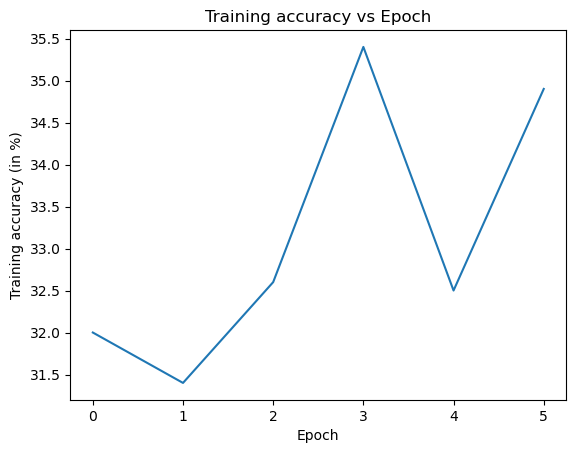

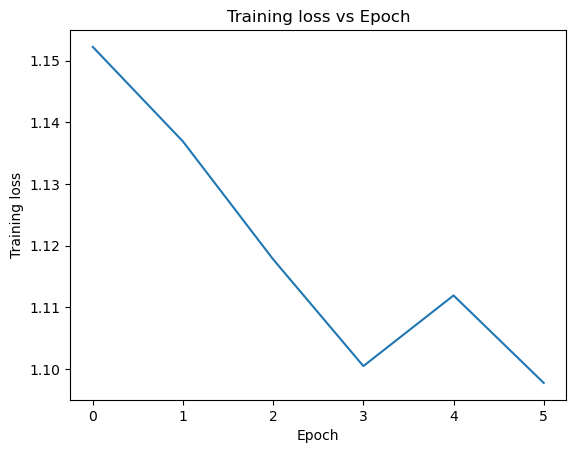

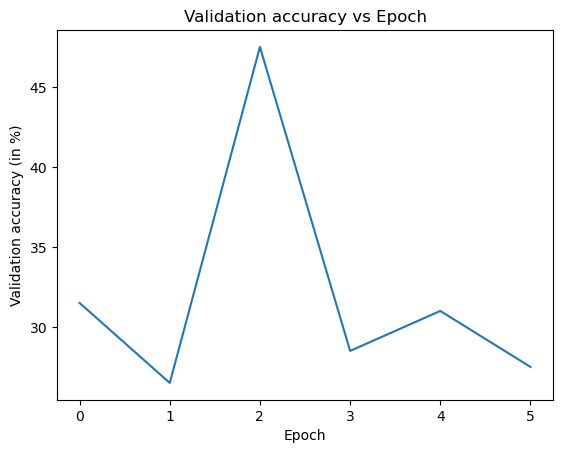

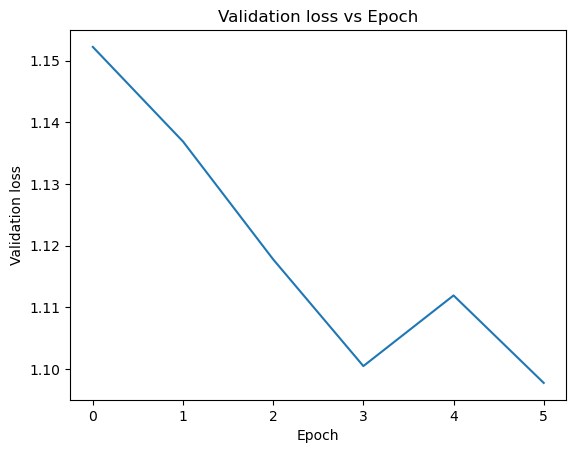

In [22]:
import copy
from copy import deepcopy

warnings.filterwarnings('ignore')

# creating the second tranformer model
tranformer_model2 = SentimentAnalysisModel2()
tranformer_model2 = tranformer_model2.to(device)

# creating the optimizer and scheduler objects for the transformer model 2
no_of_steps_for_training = epoch_limit * len(data_loader_for_training_set)
optimizer2 = AdamW(tranformer_model2.parameters(), correct_bias=False, lr=1e-5)
scheduler2 = get_linear_schedule_with_warmup(optimizer2, num_training_steps=no_of_steps_for_training, num_warmup_steps=0)


# training the model and calculating the metrics (training accuracy, validation accuracy, training loss, validation loss)
maximum_accuracy = 0
training_accuracy_list = []
training_loss_list = []
validation_loss_list = []
validation_accuracy_list = []
indexes = []
best_model_state2 = deepcopy(tranformer_model2.state_dict())


# calculating the loss and accuracy of training and validation datasets for each epoch
for i in range(epoch_limit):
    print(f"Epoch : {i + 1}")

    training_loss, training_accuracy = train_tranformer_model(data_loader_for_training_set, tranformer_model2, len(processed_output_records), scheduler2, optimizer2)

    print("Training data")
    print(f"Training accuracy = {training_accuracy}")
    print(f"Training loss = {training_loss}")

    validation_loss, validation_accuracy = evaluate_transformer_model(data_loader_for_validation_set, tranformer_model2, len(processed_output_records_validation))

    print("Validation data")
    print(f"Validation accuracy = {validation_accuracy}")
    print(f"Validation loss = {validation_loss}")

    training_accuracy_list.append(training_accuracy * 100)
    validation_accuracy_list.append(validation_accuracy * 100)
    training_loss_list.append(training_loss)
    validation_loss_list.append(validation_loss)
    indexes.append(i)
    
    print()
    print()

    if maximum_accuracy <= validation_accuracy:
        maximum_accuracy = validation_accuracy
        best_model_state2 = deepcopy(tranformer_model2.state_dict())

        
# saving the best model (which had the maximum validation accuracy)
torch.save(best_model_state2, "./best_model2.pt")
        
# printing the Training accuracy vs Epoch graph
plot_graph.plot(indexes, training_accuracy_list)
plot_graph.xlabel("Epoch")
plot_graph.ylabel("Training accuracy (in %)")
plot_graph.title("Training accuracy vs Epoch")
plot_graph.show()

print()
print()

# plotting the Training loss vs Epoch graph
plot_graph.plot(indexes, training_loss_list)
plot_graph.xlabel("Epoch")
plot_graph.ylabel("Training loss")
plot_graph.title("Training loss vs Epoch")
plot_graph.show()

print()
print()

# printing the Validation accuracy vs Epoch graph
plot_graph.plot(indexes, validation_accuracy_list)
plot_graph.xlabel("Epoch")
plot_graph.ylabel("Validation accuracy (in %)")
plot_graph.title("Validation accuracy vs Epoch")
plot_graph.show()

print()
print()

# plotting the Validation loss vs Epoch graph
plot_graph.plot(indexes, training_loss_list)
plot_graph.xlabel("Epoch")
plot_graph.ylabel("Validation loss")
plot_graph.title("Validation loss vs Epoch")
plot_graph.show()



### 2E Result analysis

In this section, we will load the best model saved during training, and report the accuracy of the model on the test set (‘yelp review test.csv’)

In [16]:
# function to calculate the accuracy of the model
def calculate_accuracy(y_predicted, y_original):
    total_size = len(y_predicted)
    no_of_correct_classifications = 0
    # finding the number of input records which are correctly classified
    for i in range(total_size):
        if y_predicted[i] == y_original[i]:
            no_of_correct_classifications += 1
    
    return no_of_correct_classifications / (1.0 * total_size)

# function to predict output from a model for the given input data
def predict_output_from_model(dataset, learning_model):
    input_list = []
    predicted_output_list = []
    predicted_output_probability_list = []
    original_output_list = []
    learning_model = learning_model.eval()

    with torch.no_grad():
        for data in dataset:
            input_id_list = data["input_id_list"].to(device)
            attention_mask = data["attention_mask"].to(device)
            output_values = data["output"].to(device)
            inputs = data["input"]
            
            predicted_outputs = learning_model(input_ids=input_id_list, attention_mask=attention_mask)
            _, predictions = torch.max(predicted_outputs, dim=1)

            input_list.extend(inputs)
            original_output_list.extend(output_values)
            predicted_output_probability_list.extend(predicted_outputs)
            predicted_output_list.extend(predictions)
            
    predicted_output_list = torch.stack(predicted_output_list).cpu()
    predicted_output_probability_list = torch.stack(predicted_output_probability_list).cpu()
    original_output_list = torch.stack(original_output_list).cpu()

    return input_list, original_output_list, predicted_output_list, predicted_output_probability_list 


    

In [17]:
# loading the best model state (highest validation accuracy) which was saved for tranformer_model1

best_transformer_model = SentimentAnalysisModel1()
best_transformer_model_state = torch.load("./best_model1.pt")
best_transformer_model.load_state_dict(best_transformer_model_state)

inputs, y_original, y_predicted, y_pred_probabilities = predict_output_from_model(data_loader_for_testing_set, best_transformer_model)


print("Testing accuracy:")
print(calculate_accuracy(y_predicted, y_original))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testing accuracy:
0.66


In [29]:
# loading the best model state (highest validation accuracy) which was saved for tranformer_model2

best_transformer_model2 = SentimentAnalysisModel2()
best_transformer_model_state2 = torch.load("./best_model2.pt")
best_transformer_model2.load_state_dict(best_transformer_model_state2)

inputs, y_original2, y_predicted2, y_pred_probabilities = predict_output_from_model(data_loader_for_testing_set, best_transformer_model2)


print("Testing accuracy:")
print(calculate_accuracy(y_predicted2, y_original2))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testing accuracy:
0.34


As we can see, model 1 has performed way better than model 2 with respect to validation accuracy and test accuracy.
I feel that the bad performance of model 2 might be because of multiple dropout layers which would have affected the already underfitting model. And the layering of model 2 has gotten way more complex compared to that of model 1.

<br> 
The model state of model 1 is stored in best_model1.pt
<br>
And the model state of model 2 is stored in best_model2.pt

### What are the impacts of hyper-parameters, such as the hidden dimension and the number of attention layers, on the Transformer?

Hidden dimension being high will help the model to gauge the complex patterns in the data. So, increasing the hidden dimension generally enhances the ability of the model to learn the relationships in the given data, but heavy computation is the tradeoff here. This applies to the number of attention layers as well. 

Batch size is another hyperparameter I experimented with. Transformers have an advantage with larger batch sizes with the parallelization of the training phase.

I also used dropout layers as they generally help avoid overfitting by deactivating nodes at random during the training.

Apart from all these, I used the learning rate which is a crucial hyperparameter when it comes to transformers. The right balance has to be found as very high learning rate might end up in divergence and very low learning rate can end up in very slow convergence or getting landed on a local minima.